_____

In [1]:
import os
import sys
sys.path.append("../utils/")
sys.path.append("../models/")
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from models import UNet
from max_model import ENet3D as ENet
from nn_utils import iterate_minibatches
from mulptiprocessing_utils import par_iterate_minibatches
from pytorch_utils import to_numpy, to_var, loss_cross_entropy, stochastic_step
from data_utils import load_files, random_nonzero_crops, augment, _reshape_to
from data_utils import combine, divide
from metrics import hausdorff, dice
from model_controller import Model_controller

%matplotlib inline

In [2]:
PATH = '../data/Utr/Utrecht/'
PATH1 = '../data/Sing/Singapore/'
PATH2 = '../data/Amst/GE3T/'

In [3]:
masks, t1, flairs, brain_mask = load_files(PATH)
brains = np.concatenate([flairs, t1], axis=1).astype(np.float32)

masks1, t11, flairs1, brain_mask1 = load_files(PATH1)
brains1 = np.concatenate([flairs1, t11], axis=1).astype(np.float32)

masks2, t12, flairs2, brain_mask2 = load_files(PATH2)
brains2 = np.concatenate([flairs2, t12], axis=1).astype(np.float32)

  0%|          | 0/20 [00:00<?, ?it/s]

INFO: brain mask from hardcoded path ../data/skull_stripping!


100%|██████████| 20/20 [00:03<00:00,  6.28it/s]


INFO: data reshape to hardcoded shapes new_shape=(256, 256, 84)!


  5%|▌         | 1/20 [00:00<00:03,  6.10it/s]

INFO: brain mask from hardcoded path ../data/skull_stripping!


100%|██████████| 20/20 [00:04<00:00,  5.09it/s]


INFO: data reshape to hardcoded shapes new_shape=(256, 256, 84)!


  5%|▌         | 1/20 [00:00<00:03,  6.10it/s]

INFO: brain mask from hardcoded path ../data/skull_stripping!


100%|██████████| 20/20 [00:03<00:00,  5.49it/s]


INFO: data reshape to hardcoded shapes new_shape=(256, 256, 84)!


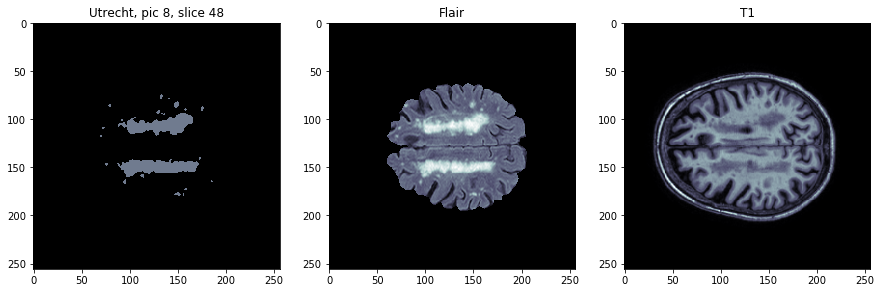

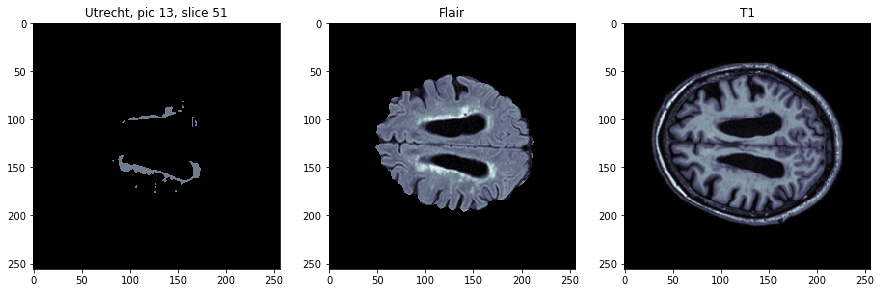

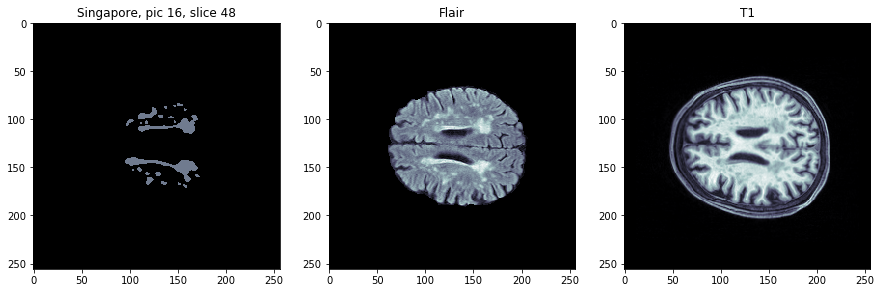

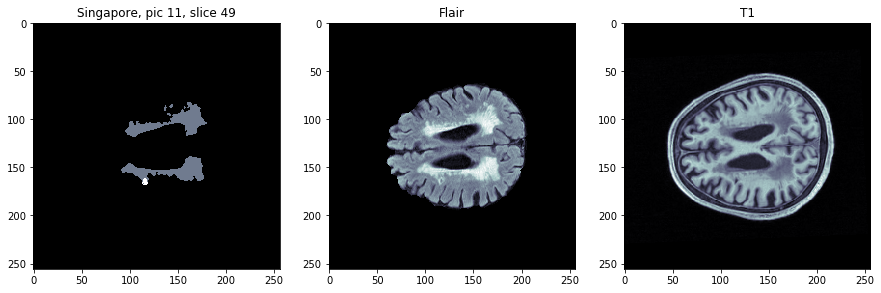

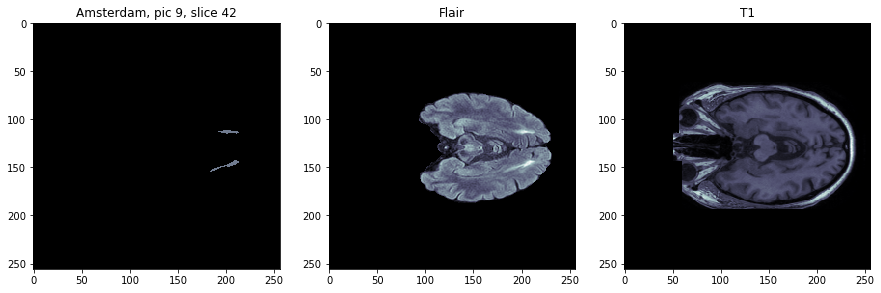

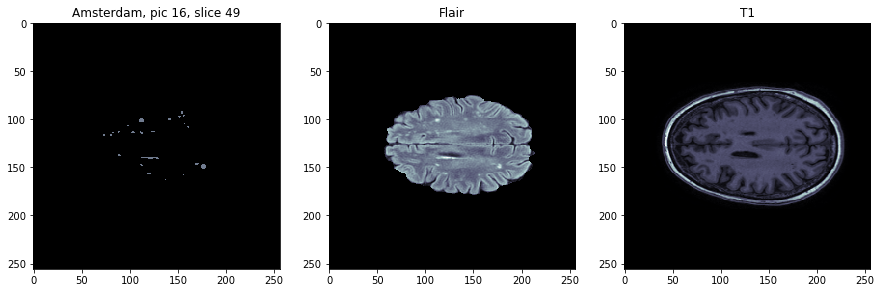

In [4]:
# Visualize

for pic in np.random.choice(range(len(masks)), 2, False):
    plt.figure(figsize=(15,5))
    mask = masks[pic, 0]
    flair = brains[pic, 0]
    tttt = brains[pic, 1]
    
    t = np.argmax(np.sum(mask[...]==1, axis=(-2, -3)))
    
    plt.subplot(1,3,1)
    plt.title('Utrecht, pic '+ str(pic)+', slice ' + str(t))
    plt.imshow(mask[:, :, t], cmap=plt.cm.bone, vmax=2)
    plt.subplot(1,3,2)
    plt.title('Flair')
    plt.imshow(flair[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,3,3)
    plt.title('T1')
    plt.imshow(tttt[:, :, t], cmap=plt.cm.bone)

for pic in np.random.choice(range(len(masks)), 2, False):
    plt.figure(figsize=(15,5))
    mask = masks1[pic, 0]
    flair = brains1[pic, 0]
    tttt = brains1[pic, 1]
    t = np.argmax(np.sum(mask[...]==1, axis=(-2, -3)))
    
    plt.subplot(1,3,1)
    plt.title('Singapore, pic '+ str(pic)+', slice ' + str(t))
    plt.imshow(mask[:, :, t], cmap=plt.cm.bone, vmax=2)
    plt.subplot(1,3,2)
    plt.title('Flair')
    plt.imshow(flair[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,3,3)
    plt.title('T1')
    plt.imshow(tttt[:, :, t], cmap=plt.cm.bone)

for pic in np.random.choice(range(len(masks)), 2, False):
    plt.figure(figsize=(15,5))
    mask = masks2[pic, 0]
    flair = brains2[pic, 0]
    tttt = brains2[pic, 1]
    t = np.argmax(np.sum(mask[...]==1, axis=(-2, -3)))
    
    plt.subplot(1,3,1)
    plt.title('Amsterdam, pic '+ str(pic)+', slice ' + str(t))
    plt.imshow(mask[:, :, t], cmap=plt.cm.bone, vmax=2)
    plt.subplot(1,3,2)
    plt.title('Flair')
    plt.imshow(flair[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,3,3)
    plt.title('T1')
    plt.imshow(tttt[:, :, t], cmap=plt.cm.bone)


_____

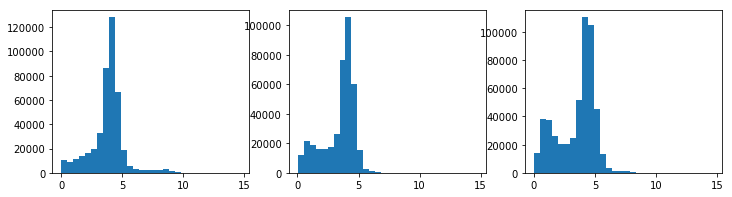

In [5]:
plt.figure(figsize=(12,3))
plt.title('hist of flairs');
plt.subplot(131)
v = brains[8, 0].flatten()
a = plt.hist(v[v!=0], bins=30);
plt.subplot(132)
v = brains1[8, 0].flatten()
plt.hist(v[v!=0], bins=a[1]);
plt.subplot(133)
v = brains2[8, 0].flatten()
plt.hist(v[v!=0], bins=a[1]);

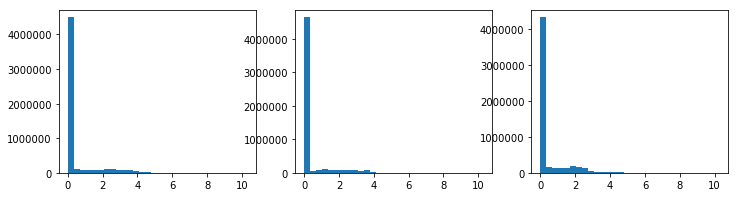

In [6]:
plt.figure(figsize=(12,3))
plt.title('hist of t1')
plt.subplot(131)
a = plt.hist(brains[8, 1].flatten(), bins=30);
plt.subplot(132)
plt.hist(brains1[8, 1].flatten(), bins=a[1]);
plt.subplot(133)
plt.hist(brains2[8, 1].flatten(), bins=a[1]);

____

In [7]:
def get_train_split(get_train_split=20, n=15):
    return np.in1d(np.array(range(get_train_split)), 
                   np.random.choice(range(get_train_split), n, False))

In [8]:
idx1, idx2, idx3 = get_train_split(), get_train_split(), get_train_split()
idx1, idx2, idx3

(array([ True,  True,  True,  True, False,  True, False,  True,  True,
         True, False,  True,  True, False,  True,  True,  True, False,
         True,  True], dtype=bool),
 array([ True,  True, False,  True,  True,  True,  True, False,  True,
         True,  True, False,  True,  True,  True, False,  True, False,
         True,  True], dtype=bool),
 array([False, False,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True, False,  True,
         True,  True], dtype=bool))

X_train = np.concatenate([brains[idx1]])
X_test = np.concatenate([brains[~idx1]])
Y_train = np.concatenate([masks[idx1]])
Y_test = np.concatenate([masks[~idx1]])

___

In [9]:
from sklearn.model_selection import KFold
skf = KFold(n_splits=4, random_state=0, shuffle=True)

In [10]:
import pickle

In [ ]:

counter=0
for tr_idx, ts_idx in skf.split(range(len(brains)), range(len(masks))):
    counter+=1
    X_train = np.concatenate([brains[tr_idx], brains1[tr_idx], brains2[tr_idx]])
    X_test = np.concatenate([brains[ts_idx], brains1[ts_idx], brains2[ts_idx]])
    Y_train = np.concatenate([masks[tr_idx], masks1[tr_idx], masks2[tr_idx]])
    Y_test = np.concatenate([masks[ts_idx], masks1[ts_idx], masks2[ts_idx]])
    
    model = UNet().cuda()
    controller = Model_controller(model)
    
    controller.init_train_procedure(batch_size = 30, crops_shape=(50, 50, 40), 
                                lr_decayer=lambda x: x*0.7, lr=0.01, net='3D',
                                decay_every_epoch=20, num_of_patches=500)
    
    controller.train(X_train, Y_train, epoches=100, X_val=X_test, y_val=Y_test)
    y = controller.predict(X_test)
    
    np.savez('../reports/figures/3D_UNet/y_dump_'+str(counter)+'.npy', y)
    
    for num_img in range(len(Y_test)):
        plt.figure()
        t = np.argmax(np.sum(Y_test[num_img, 0, ...]==1, axis=(-2, -3)))
        plt.subplot(121)
        plt.imshow(y[num_img, ..., t], cmap=plt.cm.binary_r)
        plt.title('dice: ' + str(dice(y[num_img], Y_test[num_img,0]))[:5])
        plt.subplot(122)
        plt.imshow(Y_test[num_img, 0,..., t], cmap=plt.cm.binary_r, vmax=2)
        plt.savefig('../reports/figures/3D_UNet/'+str(counter)+'_'+str(num_img)+'.png')
        
        plt.figure()
        plt.plot(controller.res['train_loss'], label='train')
        plt.plot(controller.res['val_loss'], label='val')
        plt.legend();
        plt.savefig('../reports/figures/3D_UNet/'+str(counter)+'_tr_val_3D_UNet.png')
        

0.0658: 100%|██████████| 16/16 [00:34<00:00,  2.11s/it]


0 epoch: 
train loss 0.22347402921877801


0.0850: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


val loss 0.08616458810865879


0.0542: 100%|██████████| 16/16 [00:36<00:00,  2.25s/it]


1 epoch: 
train loss 0.09956488572061062


0.0331: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


val loss 0.04394838120788336


0.0564: 100%|██████████| 16/16 [00:36<00:00,  2.24s/it]


2 epoch: 
train loss 0.07289283606223762


0.0353: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


val loss 0.04241535998880863


0.0433: 100%|██████████| 16/16 [00:36<00:00,  2.24s/it]


3 epoch: 
train loss 0.060976225417107344


0.0329: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


val loss 0.033209836576133966


0.0667: 100%|██████████| 16/16 [00:36<00:00,  2.23s/it]


4 epoch: 
train loss 0.05132613191381097


0.0329: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


val loss 0.032770467922091484


0.0423:  29%|██▉       | 5/17 [00:11<00:28,  2.34s/it]

In [12]:
model = UNet().cuda()

# model = ENet(3, 2).cuda()

controller = Model_controller(model)

controller.init_train_procedure(batch_size = 30, crops_shape=(50, 50, 40), 
                                lr_decayer=lambda x: x*0.7, lr=0.01,
                                decay_every_epoch=20)
# crops_shape=(80, 80, 40))

In [ ]:
controller.train(X_train, Y_train, epoches=100, X_val=X_test, y_val=Y_test)

____

In [14]:
y = controller.predict(X_test)

In [15]:
y.shape, Y_test.shape, y.sum()

((15, 256, 256, 84), (15, 1, 256, 256, 84), 27031)

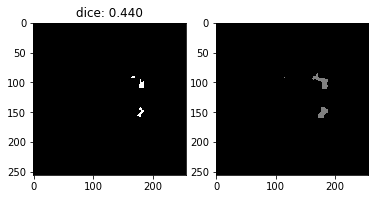

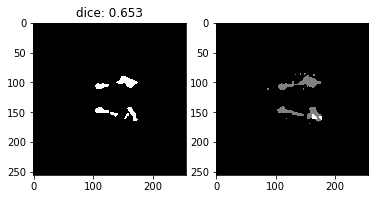

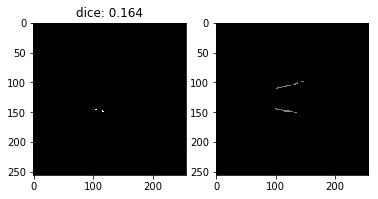

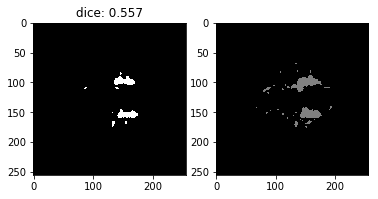

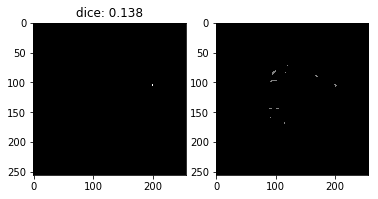

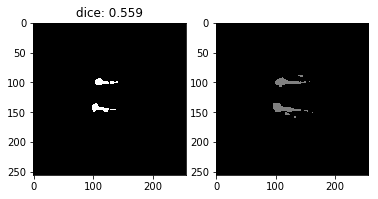

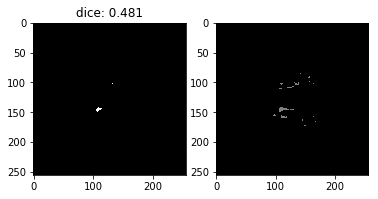

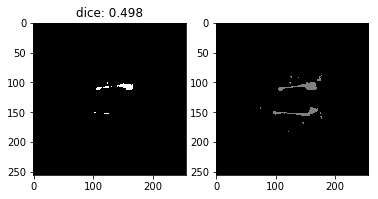

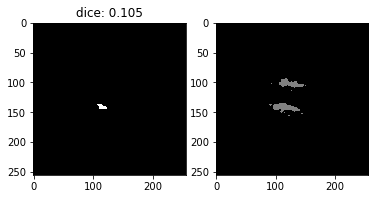

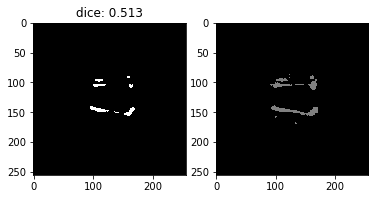

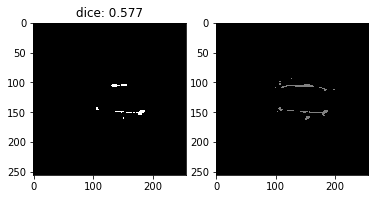

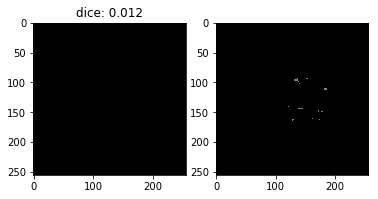

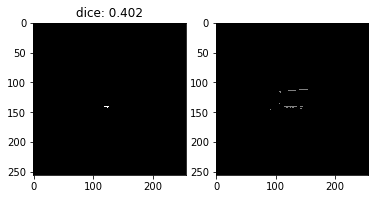

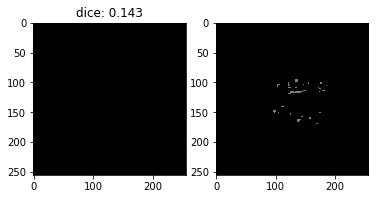

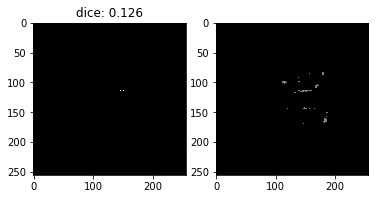

In [16]:
for num_img in range(len(Y_test)):
    plt.figure()
    t = np.argmax(np.sum(Y_test[num_img, 0, ...]==1, axis=(-2, -3)))
    plt.subplot(121)
    plt.imshow(y[num_img, ..., t], cmap=plt.cm.binary_r)
    plt.title('dice: ' + str(dice(y[num_img], Y_test[num_img,0]))[:5])
    plt.subplot(122)
    plt.imshow(Y_test[num_img, 0,..., t], cmap=plt.cm.binary_r, vmax=2)
    
    plt.savefig('../reports/figures/3D_UNet/'+str(num_img)+'.png')

#     with open('../reports/figures/3D_UNet/README.md', 'w') as f:
#         for i in range(len(X_test)):
#             f.write('![./figures/3D_UNet/'+str(i)+'.png](./figures/3D_UNet/'+str(i)+'.png)\n')
        

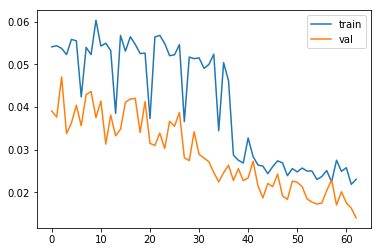

In [17]:
plt.plot(controller.res['train_loss'], label='train')
plt.plot(controller.res['val_loss'], label='val')
plt.legend();
plt.savefig('../reports/figures/tr_val_3D_UNet.png')

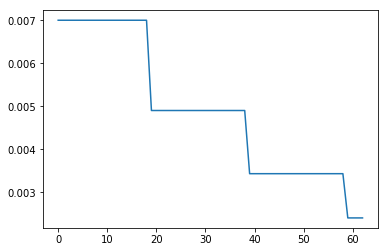

In [18]:
plt.plot(controller.res['lr'])

___

In [ ]:
import pickle
with open('../models/dumps/model_unetcnn.pkl', 'wb') as f:
    pickle.dump(controller.model.state_dict(), f, protocol=pickle.HIGHEST_PROTOCOL)